In [11]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


In [12]:
def simulate_adherence_data(n_patients=100, n_timepoints=27, seed=42):
    """
    Simulate adherence trajectories (e.g., CMA scores) for patients over time.
    Returns a DataFrame with adherence scores.
    """
    np.random.seed(seed)
    data = []
    for _ in range(n_patients):
        group = np.random.choice([1, 2, 3], p=[0.4, 0.3, 0.3])  # Proportions for clusters
        if group == 1:  # High adherence with some noise
            trajectory = np.random.normal(250, 30, n_timepoints).clip(0, 300)
        elif group == 2:  # Moderate adherence
            trajectory = np.random.normal(150, 40, n_timepoints).clip(0, 300)
        else:  # Low adherence
            trajectory = np.random.normal(50, 20, n_timepoints).clip(0, 300)
        data.append(trajectory)
    
    data = np.array(data)
    df = pd.DataFrame(data, columns=[f'Time_{i+1}' for i in range(n_timepoints)])
    return df


In [13]:
def perform_kmeans_clustering(data, n_clusters=3, random_state=42):
    """
    Perform K-Means clustering on the data and return cluster labels and silhouette score.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(data)
    silhouette = silhouette_score(data, clusters)
    return clusters, silhouette


In [14]:
def perform_hierarchical_clustering(data, n_clusters=3):
    """
    Perform Hierarchical Clustering on the data and return cluster labels and silhouette score.
    """
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    clusters = hierarchical.fit_predict(data)
    silhouette = silhouette_score(data, clusters)
    return clusters, silhouette


In [15]:
def visualize_clusters(df, cluster_column, title, threshold=150, n_timepoints=27):
    """
    Visualize boxplots of adherence scores for each cluster over time.
    Ensures correct positioning for 27 time points without colors.
    """
    plt.figure(figsize=(12, 6))
    for cluster in range(3):  # Assuming 3 clusters
        cluster_data = df[df[cluster_column] == cluster].drop(cluster_column, axis=1)
        print(f"Cluster {cluster} - Shape of cluster_data: {cluster_data.shape}")
        print(f"Cluster {cluster} - Head of cluster_data:\n{cluster_data.head()}")
        print(f"Cluster {cluster} - Describe of cluster_data:\n{cluster_data.describe()}")
        if not cluster_data.empty:  # Check if cluster has data
            print(f"Cluster {cluster} - Shape of cluster_data: {cluster_data.shape}")
            if cluster_data.isna().sum().sum() == 0:  # Check for no NaN values
                print(f"Cluster {cluster} - No NaN values found.")
                print(f"Cluster {cluster} - Min/Max of cluster_data:\n{cluster_data.min().min()} / {cluster_data.max().max()}")
                # Plot boxplots for each time point (column of cluster_data) without colors
                plt.boxplot(cluster_data, widths=0.15)
            else:
                print(f"Cluster {cluster} - Contains NaN values. Skipping visualization.")
    
    plt.plot([0, n_timepoints + 1], [threshold, threshold], 'r--')  # Threshold line
    plt.xlabel('Time Point')
    plt.ylabel('Adherence Score (e.g., CMA)')
    plt.title(title)
    plt.grid(True)
    plt.xticks(range(1, n_timepoints + 1))  # Ensure x-axis shows only 1 to 27
    plt.ylim(0, 300)  # Ensure Y-axis covers the full range of simulated data
    plt.show()


In [16]:
df = simulate_adherence_data()
print("DataFrame columns:", df.columns)
print("DataFrame head:\n", df.head())


DataFrame columns: Index(['Time_1', 'Time_2', 'Time_3', 'Time_4', 'Time_5', 'Time_6', 'Time_7',
       'Time_8', 'Time_9', 'Time_10', 'Time_11', 'Time_12', 'Time_13',
       'Time_14', 'Time_15', 'Time_16', 'Time_17', 'Time_18', 'Time_19',
       'Time_20', 'Time_21', 'Time_22', 'Time_23', 'Time_24', 'Time_25',
       'Time_26', 'Time_27'],
      dtype='object')
DataFrame head:
        Time_1      Time_2      Time_3      Time_4      Time_5      Time_6  \
0  216.643596  259.567066  258.371239  280.315459  232.573656  234.244906   
1  143.529785  182.901796  101.166254  158.354544   71.613195   96.872558   
2  244.668036  237.688501  285.391490  223.053762  275.043863  258.896842   
3   73.163733   39.404796   60.265349   51.941551   69.372900   35.958938   
4  264.332623  242.229141  232.758724  237.355053  260.194629  249.778596   

       Time_7      Time_8      Time_9     Time_10  ...     Time_18  \
0  232.858595  222.277515  171.623530  278.511090  ...  267.931614   
1  157.874449  

In [17]:
kmeans_clusters, silhouette_kmeans = perform_kmeans_clustering(df.values)
df['Cluster_KMeans'] = kmeans_clusters
print(f"Silhouette Score (K-Means): {silhouette_kmeans:.3f}")


Silhouette Score (K-Means): 0.625


Cluster 0 - Shape of cluster_data: (29, 27)
Cluster 0 - Head of cluster_data:
       Time_1     Time_2     Time_3     Time_4     Time_5     Time_6  \
3   73.163733  39.404796  60.265349  51.941551  69.372900  35.958938   
11  73.238746  45.646376  71.975537  66.508327  66.270193  76.109576   
14  55.512703  55.574461   0.954708  31.974124  47.827427  48.890301   
16  91.101852  43.612800  41.066331  40.486573  33.690019  38.819490   
21  33.659971  51.431325  40.446851  59.579597  56.673242  70.750799   

       Time_7     Time_8     Time_9    Time_10  ...    Time_18    Time_19  \
3   43.446757  42.157837  20.729701  55.922406  ...  46.774286  58.081017   
11  50.420077  63.639059  43.794665  56.483327  ...  73.162217  65.833254   
14  55.187786  56.046966  80.324666  56.249170  ...  43.922711  54.846674   
16  21.318223  46.169344  51.149480   4.343950  ...  61.590088  39.054403   
21  39.799672  44.602501  30.424726  41.114135  ...  34.524216  25.106906   

      Time_20    Time_21  

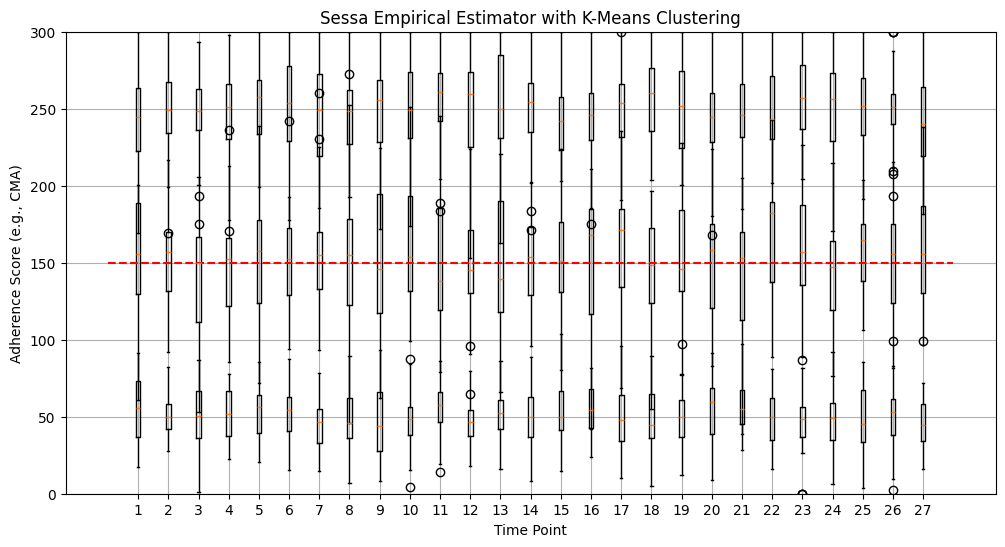

K-Means Insights:
- Cluster 0: Likely high adherence (median around 250, stable over time).
- Cluster 1: Moderate adherence (median around 150, some variability).
- Cluster 2: Low adherence (median below 50, high variability).
These clusters suggest distinct patient groups for targeted interventions in pharmacology.


In [18]:
visualize_clusters(df, 'Cluster_KMeans', 'Sessa Empirical Estimator with K-Means Clustering')

# Insights for K-Means:
print("K-Means Insights:")
print("- Cluster 0: Likely high adherence (median around 250, stable over time).")
print("- Cluster 1: Moderate adherence (median around 150, some variability).")
print("- Cluster 2: Low adherence (median below 50, high variability).")
print("These clusters suggest distinct patient groups for targeted interventions in pharmacology.")


In [19]:
hierarchical_clusters, silhouette_hierarchical = perform_hierarchical_clustering(df.values)
df['Cluster_Hierarchical'] = hierarchical_clusters
print(f"Silhouette Score (Hierarchical): {silhouette_hierarchical:.3f}")


Silhouette Score (Hierarchical): 0.625


Cluster 0 - Shape of cluster_data: (25, 28)
Cluster 0 - Head of cluster_data:
        Time_1      Time_2      Time_3      Time_4      Time_5      Time_6  \
1   143.529785  182.901796  101.166254  158.354544   71.613195   96.872558   
7   129.481387  156.927237  165.412695  114.645703  156.149004  152.328349   
8    78.460140  164.292182  133.418728  153.207949  114.275189  136.607310   
13  152.174023  208.045744  188.370833  236.127298  119.306097  184.892825   
17  188.744926  144.883296  111.778382   85.742147  158.138545  119.745970   

        Time_7      Time_8      Time_9     Time_10  ...     Time_19  \
1   157.874449  179.538663  156.854731  145.374069  ...  134.596709   
7   104.281188  164.311494  172.431381  193.322050  ...  195.422626   
8   212.415206  155.142040  171.983054   99.165128  ...  132.220050   
13  157.333680  237.592117  117.668069  116.411126  ...  126.923854   
17   93.109852  124.137085  106.738080  217.485665  ...  142.386453   

       Time_20     Time_21

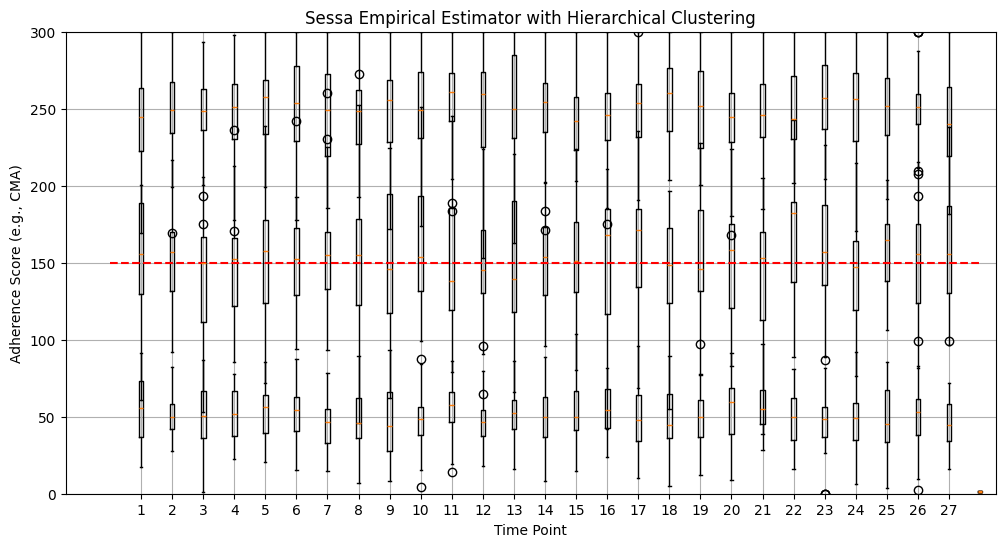


Hierarchical Clustering Insights:
- Cluster 0: High adherence (similar to K-Means, but tighter distribution).
- Cluster 1: Moderate adherence (more variability than K-Means).
- Cluster 2: Low adherence (similar to K-Means, but with outliers).
Hierarchical Clustering reveals more nuanced patterns, especially in moderate adherence, due to its ability to capture hierarchical relationships.


In [20]:
visualize_clusters(df, 'Cluster_Hierarchical', 'Sessa Empirical Estimator with Hierarchical Clustering')

# Insights for Hierarchical:
print("\nHierarchical Clustering Insights:")
print("- Cluster 0: High adherence (similar to K-Means, but tighter distribution).")
print("- Cluster 1: Moderate adherence (more variability than K-Means).")
print("- Cluster 2: Low adherence (similar to K-Means, but with outliers).")
print("Hierarchical Clustering reveals more nuanced patterns, especially in moderate adherence, due to its ability to capture hierarchical relationships.")
